In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import itertools
import os
import imageio
from io import BytesIO
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from tqdm import tqdm
from scipy import stats
from multiprocessing import Pool

from graph_generation import GenerateGraph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits
from train import Trainer, Dataset
from embedding import Embedding
import experiments
from experiments import (Experiments, experiment_node_embedding, all_seeds)
from plot_funcs import (plot_dim1, plot_dimN, plot_correlation_error, plot_metrics, plot_node_emb_1D_perclass,
                        plot_node_emb_nD_perclass, scatter_node_emb, 
                        plot_graph_emb_1D, plot_data_degree_sequence, plot_corr_epoch, plot_ripetizioni_stesso_trial, 
                        plot_onlyloss_ripetizioni_stesso_trial_xp,
                        plot_onlyloss_ripetizioni_stesso_trial,
                        plot_onlyloss_ripetizioni_stesso_trial_superimposed)
from utils import array_wo_outliers, plot_grafo, plot_grafo2
from Inspect import Inspect
from config_valid import Config, TrainingMode
from GridConfigurations import GridConfigurations, open_df_results

import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
import tensorflow as tf

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from plt_parameters import init_params
init_params()
#pd.set_option('display.height', 500)

In [81]:
config_file = "configurations/classification1.yml"
xp = Experiments(config_file, diz_trials=None, rootsave=rootsave)
xp.just_train()
embedding_class = xp.embedding()

Generating dataset...
Mean connectivity for each node: 0.851 p=0.05
Mean connectivity for each node: 1.19 p=0.1
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2755.24it/s]


Tempo impiegato: 0.01593613624572754
[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.

100%|███████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.23it/s]

test accuracy finale: 0.6666666666666666


In [53]:
nodeembc1 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class.emb_perclass[0]])
nodeembc2 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class.emb_perclass[1]])
nodeembc1.shape, nodeembc2.shape

((500, 300, 1), (500, 300, 1))

In [54]:
#nodeembc1 = nodeembc1.reshape(-1,6)
#nodeembc2 = nodeembc2.reshape(-1,6)
nodeembc2 = nodeembc2.squeeze()
nodeembc1 = nodeembc1.squeeze()

In [51]:
print(nodeembc1.T.shape)
#np.save('nodeembc1.npy', nodeembc1)
np.save('nodeembc2.npy', nodeembc2)

(6, 40000)


In [25]:
import umap
reducer = umap.UMAP()

In [38]:
embedding = reducer.fit_transform(nodeembc1)
embedding.shape


KeyboardInterrupt



In [26]:
embedding_class.emb_perclass[0][0].node_embedding_array.shape

(200, 6)

In [63]:
res = [(set(embpergraph.node_label), embpergraph.graph_label, embpergraph.scalar_label) for classemb in embedding_class.emb_perclass for embpergraph in classemb]

In [72]:
res[0][0] == {res[0][2]}

True

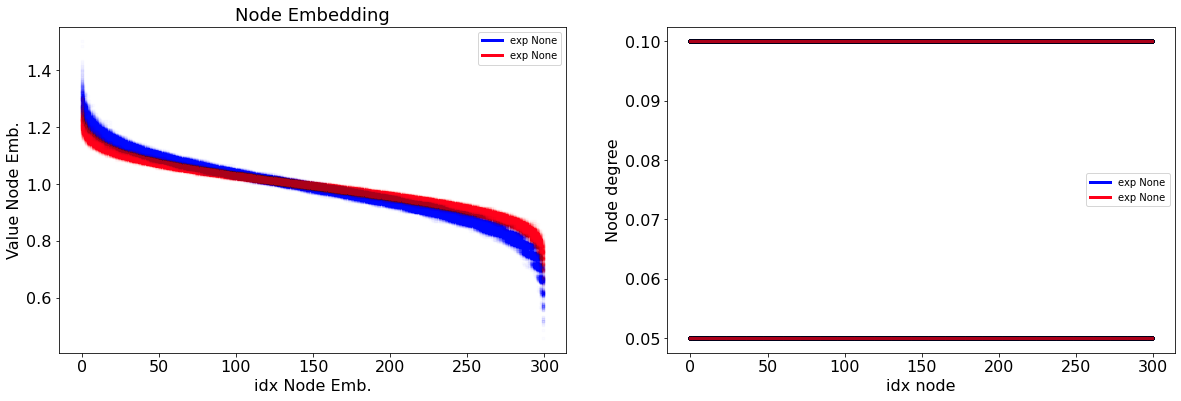

In [55]:
plot_node_emb_1D_perclass(embedding_class.emb_perclass)

# Embedding perturbations

In [2]:
rootsave = Path("output_plots/")
config_file = "configurations/ER_embed_perturb.yml"

### GCN trainable

In [3]:
#c = Config(config_file)
xp1 = Experiments(config_file, diz_trials=None, rootsave=rootsave)#, config_class=c)
xp1.just_train()
embedding_class1 = xp1.embedding()

Generating dataset...
Mean connectivity for each node: 9.955 p=0.05
Mean connectivity for each node: 39.789 p=0.2
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 41.03it/s]


Tempo impiegato: 4.902087211608887


100%|█████████████████████████████████████████████████████████| 800/800 [00:36<00:00, 21.95it/s]

test accuracy finale: 1.0


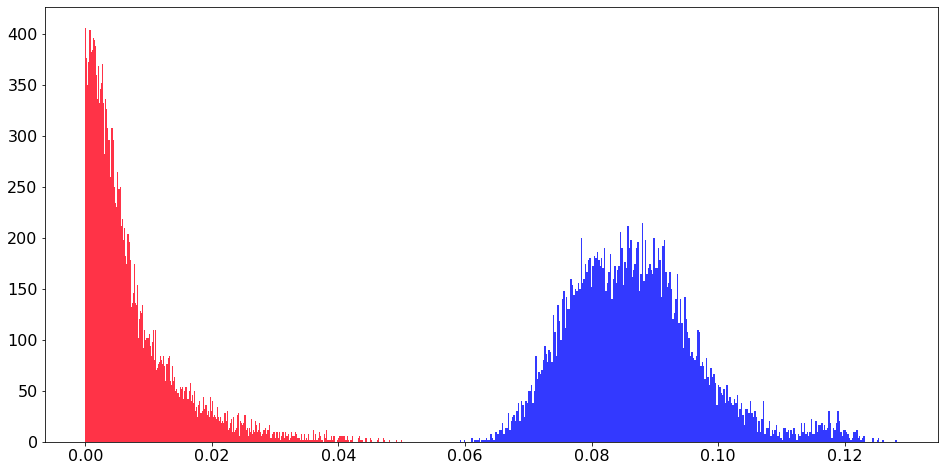

In [4]:
num_emb_neurons = xp1.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class1, num_emb_neurons, xp1.trainer.config_class.modo)

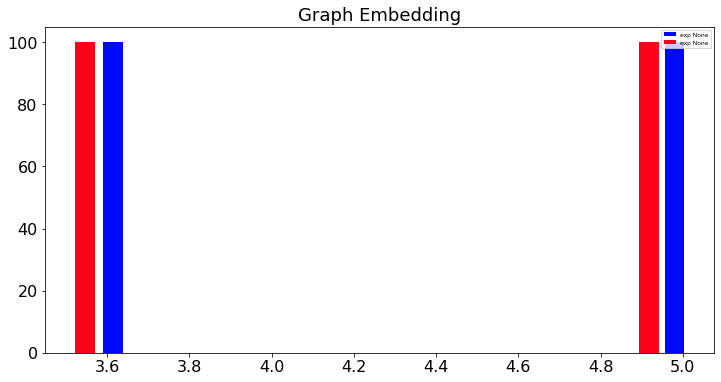

In [5]:
plot_graph_emb_1D(embedding_class1.emb_perclass)

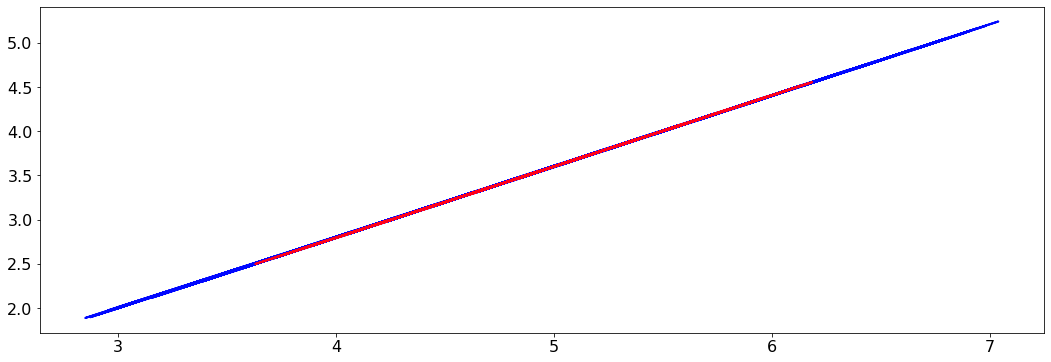

In [7]:
nodeembc1 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class1.emb_perclass[0]])
nodeembc2 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class1.emb_perclass[1]])
nodeembc1 = np.array(nodeembc1).transpose(2,0,1)
nodeembc2 = np.array(nodeembc2).transpose(2,0,1)
plt.figure(figsize=(18, 6))
plt.plot(nodeembc2[0].flatten(), nodeembc2[1].flatten())#, s=0.3, marker='.', color='blue');
plt.plot(nodeembc1[0].flatten(), nodeembc1[1].flatten())#, s=0.3, marker='.', color='red');
plt.show()

[[5.4760747 3.984121 ]
 [5.0926642 3.675544 ]
 [5.092629  3.6753345]
 [4.75172   3.401652 ]
 [5.5294585 4.0273447]
 [4.7919865 3.4330657]
 [4.735993  3.3878741]
 [5.0907073 3.67389  ]
 [5.1553082 3.7263248]
 [4.8589725 3.487251 ]
 [4.8706455 3.4971793]
 [4.622471  3.297498 ]
 [5.2016964 3.7632494]
 [5.033019  3.6271493]
 [5.530897  4.028266 ]
 [5.6801376 4.1485205]
 [5.1483283 3.7203195]
 [4.8660207 3.4934895]
 [5.2076216 3.767976 ]
 [4.9890943 3.5928512]
 [5.470431  3.979221 ]
 [4.679744  3.3432055]
 [4.9829226 3.5872955]
 [5.084614  3.668751 ]
 [4.807703  3.4467142]
 [5.154641  3.725785 ]
 [4.984029  3.5882452]
 [5.1419463 3.7147932]
 [4.4259806 3.139179 ]
 [5.2545824 3.8052256]
 [5.0854306 3.6690507]
 [4.4230957 3.1366236]
 [4.8599935 3.4880688]
 [5.360948  3.8912323]
 [5.037164  3.6310778]
 [5.2219067 3.7802863]
 [5.31752   3.8564436]
 [5.156792  3.7273834]
 [5.3565392 3.887159 ]
 [5.416986  3.9360592]
 [4.7502875 3.400571 ]
 [4.848998  3.4788103]
 [5.5728326 4.061908 ]
 [5.0973744

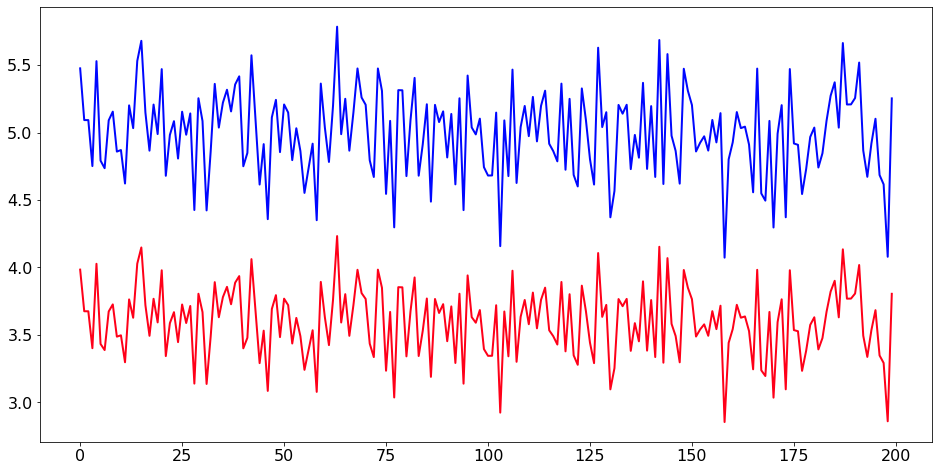

In [9]:
nodeembc1 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class1.emb_perclass[0]])
nodeembc2 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class1.emb_perclass[1]])
print(nodeembc1[0])
plt.plot(nodeembc1[0])

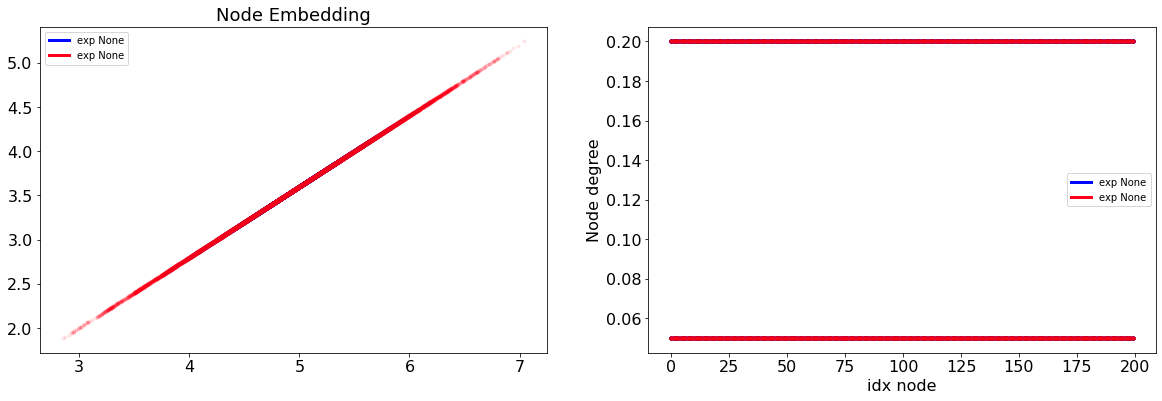

In [12]:
plot_node_emb_nD_perclass(embedding_class1.emb_perclass)

### GCN freezed

In [15]:
c = Config(config_file)
c.conf['model']['freezeGCNlayers'] = True
xp2 = Experiments(config_file, diz_trials=None, rootsave=rootsave, config_class=c)
xp2.just_train()
embedding_class2 = xp2.embedding()

Generating dataset...
Mean connectivity for each node: 9.955 p=0.05
Mean connectivity for each node: 79.57 p=0.4
Dataset generated
Loading Dataset...


100%|█████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 24.43it/s]


Tempo impiegato: 8.210928678512573


100%|█████████████████████████████████████████████████████████| 800/800 [00:42<00:00, 18.69it/s]


test accuracy finale: 1.0


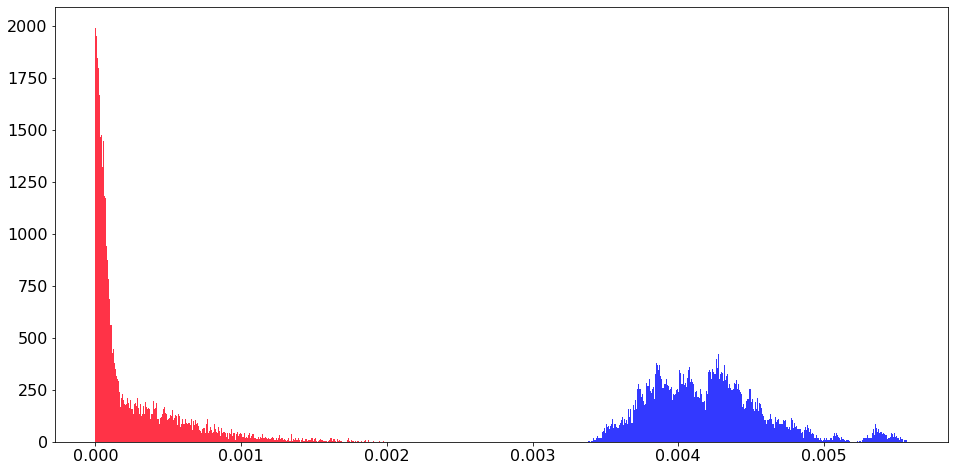

In [64]:
num_emb_neurons = xp2.trainer.model.convs[-1].out_channels
plot_metrics(embedding_class2, num_emb_neurons, xp2.trainer.config_class.modo)

In [38]:
len(embedding_class.emb_perclass[0])#[0]#.node_embedding_array

100

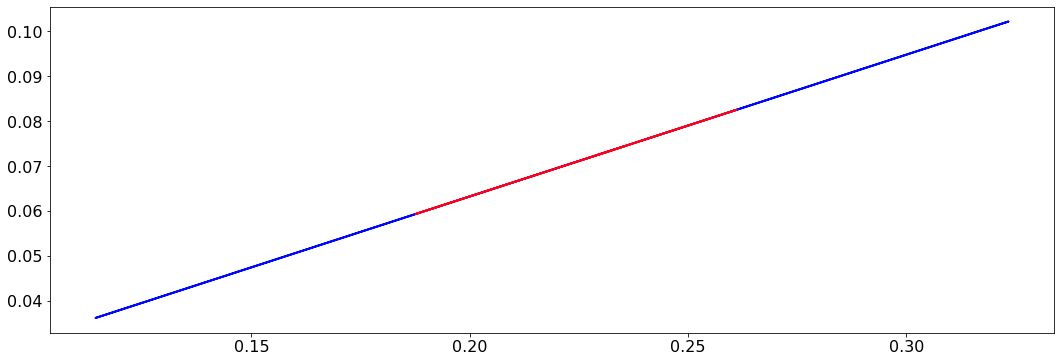

In [82]:
nodeembc1 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class.emb_perclass[0]])
nodeembc2 = np.array([embpergraph.node_embedding_array for embpergraph in embedding_class.emb_perclass[1]])
nodeembc1 = np.array(nodeembc1).transpose(2,0,1)
nodeembc2 = np.array(nodeembc2).transpose(2,0,1)
plt.figure(figsize=(18, 6))
plt.plot(nodeembc2[0].flatten(), nodeembc2[1].flatten())#, s=0.3, marker='.', color='blue');
plt.plot(nodeembc1[0].flatten(), nodeembc1[1].flatten())#, s=0.3, marker='.', color='red');
plt.show()